In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [27]:
data = pd.read_csv("Datasets/training.csv")

In [17]:
data.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,...,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire,month
0,2023-10-24 08:00:00+00:00,22.922499,58.003628,14.2225,22.934956,0.0,0.0,0.0,0.0,0.0,...,22.122500,23.972500,22.172499,18.5225,0.152,0.203,0.243,0.205,0,10
1,2022-11-09 00:00:00+00:00,18.571500,81.909440,15.4215,18.963050,0.0,0.0,0.0,0.0,0.0,...,21.271502,22.671501,22.271502,20.3715,0.425,0.433,0.423,0.405,1,11
2,2023-09-11 17:00:00+00:00,22.240500,27.772692,2.7405,18.372614,0.0,0.0,0.0,0.0,0.0,...,24.990500,19.740500,19.790499,18.7405,0.069,0.088,0.120,0.209,0,9
3,2023-10-06 01:00:00+00:00,17.717500,96.893280,17.2175,19.324417,0.0,0.0,0.0,0.0,0.0,...,22.517500,25.717500,23.117500,22.2175,0.117,0.136,0.186,0.275,0,10
4,2023-11-30 15:00:00+00:00,34.603500,29.610748,14.3035,36.488297,0.0,0.0,0.0,0.0,0.0,...,32.953503,27.253500,25.253500,24.0535,0.309,0.347,0.184,0.170,0,11


In [18]:
data.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm', 'fire', 'month'],
      dtype='object')

In [19]:
data['date'] = pd.to_datetime(data['date'])

data = data.sort_values('date')


data['hour_sin'] = np.sin(2 * np.pi * data['date'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['date'].dt.hour / 24)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['date'].dt.dayofyear / 365)
data['day_of_year_cos'] = np.cos(2 * np.pi * data['date'].dt.dayofyear / 365)

data = data.drop(columns=['date'])

In [20]:
X = data.drop(columns=['fire'])
y = data['fire']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

sequence_length = 7  

def create_sequences(X, y, sequence_length):
    sequences = []
    labels = []
    for i in range(len(X) - sequence_length):
        seq = X[i:i+sequence_length]
        label = y[i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, X.shape[1]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\giris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 64)               │          25,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,049 (148.63 KB)

 Trainable params: 38,049 (148.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7227 - loss: 0.5326 - val_accuracy: 0.7899 - val_loss: 0.4277
Epoch 2/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7993 - loss: 0.4279 - val_accuracy: 0.7804 - val_loss: 0.4463
Epoch 3/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8142 - loss: 0.4041 - val_accuracy: 0.8119 - val_loss: 0.3948
Epoch 4/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8216 - loss: 0.3919 - val_accuracy: 0.8174 - val_loss: 0.3924
Epoch 5/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8285 - loss: 0.3833 - val_accuracy: 0.8232 - val_loss: 0.3808
Epoch 6/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8312 - loss: 0.3754 - val_accuracy: 0.8252 - val_loss: 0.3835
Epoch 7/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8336 - loss: 0.3756 - val_accuracy: 0.8253 - val_loss: 0.3759
Epoch 8/50
4693/4693 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8370 - loss: 0

Accuracy: 82.58%
Precision: 77.93%
Recall: 90.76%
F1 Score: 83.86%

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.89      0.74      0.81     16134
        Fire       0.78      0.91      0.84     16047

    accuracy                           0.83     32181
   macro avg       0.83      0.83      0.82     32181
weighted avg       0.83      0.83      0.82     32181



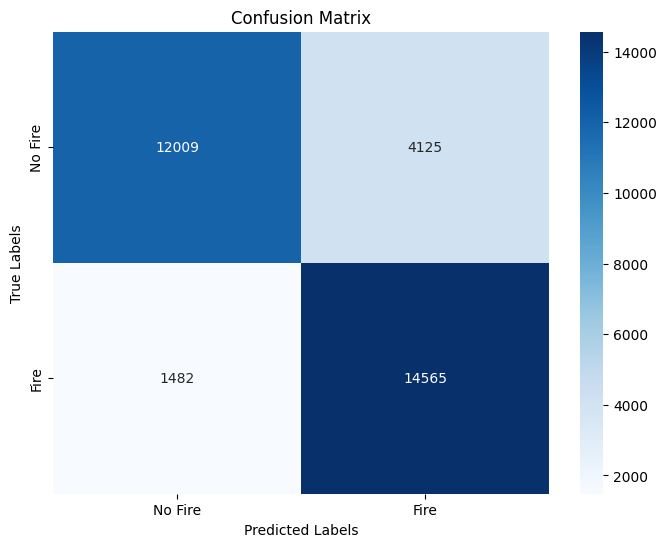

In [31]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy}")

# y_pred = (model.predict(X_test) > 0.5).astype(int)

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%\n")

report = classification_report(y_test, y_pred, target_names=['No Fire', 'Fire'])
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

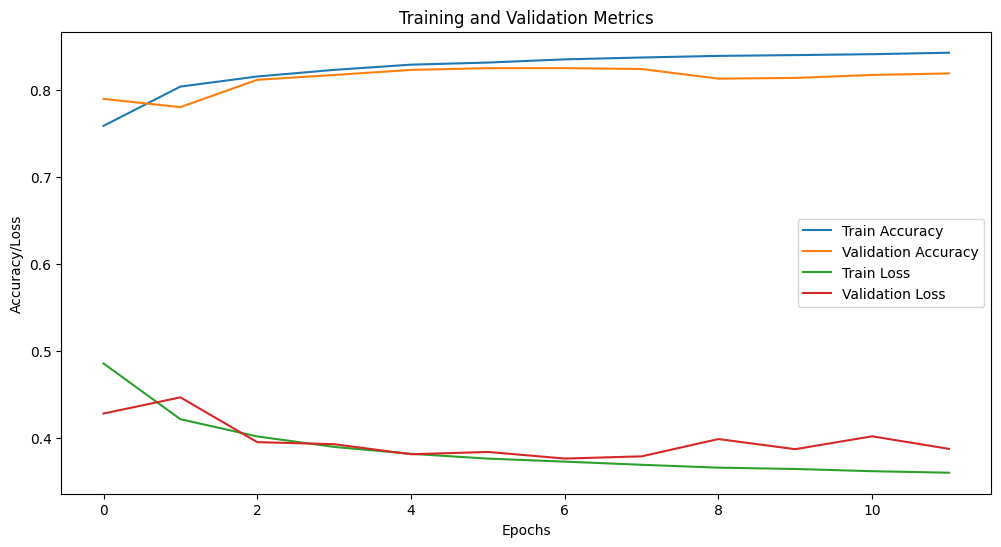

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training and Validation Metrics')
plt.show()

In [34]:
y_pred_probs = model.predict(X_test).ravel()  
y_pred = (y_pred_probs > 0.5).astype(int)  

1006/1006 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


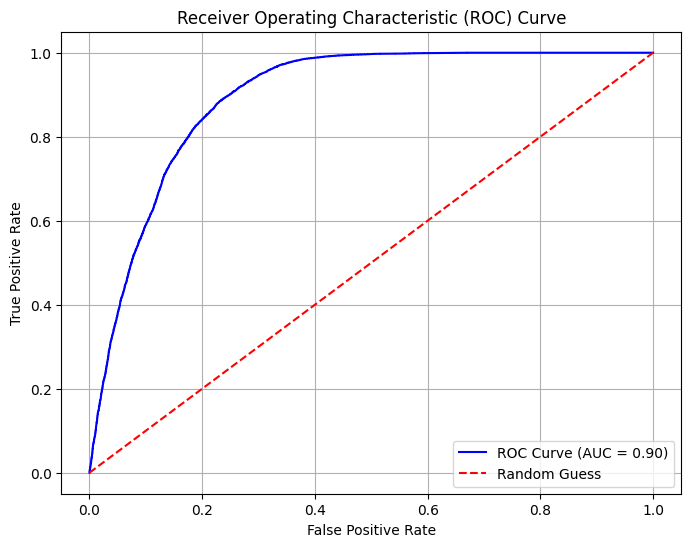

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)  
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()